# DAML notes
## 7. Model selection and evaluation 
<hr style="border:2px solid black"> </hr>

In [1]:
# RUN THIS CELL FIRST

# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Sklearn imports
from sklearn.datasets import make_moons, make_blobs, load_iris, make_classification
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.discriminant_analysis import (
    QuadraticDiscriminantAnalysis,
    LinearDiscriminantAnalysis,
)
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay

# This makes matplotlib output nice figures without much tweaking
plt.rcParams.update(
    {
        "lines.markersize": 10,  # Big points
        "font.size": 15,  # Larger font
        "xtick.major.size": 5.0,  # Bigger xticks
        "ytick.major.size": 5.0,  # Bigger yticks
    }
)

Before we go onto the main theme of the week (model selection and evaluation as it would happen) we're going to do a tour of some other models for classification. These are models that didn't quite make the cut on the course syllabus, but are relevant and worth being aware of. 

### 7.1 $k$-nearest neighbours ($k$-NN)

This is a very simple non-parametric model for classification (we'll look at non-parametric models in more detail in the next two weeks).

$k$-NN has a single hyperparameter $k$. Given a training set of $N$ data point-target pairs $\{(\mathbf{x}^{(n)}, y^{(n)})\}_{n=1}^{N}$, a new point can be classified by

1. Computing the distance between the new point and every training point
2. Identifying the $k$ training points with the lowest distance to the new point
3. Taking the mode class label of these $k$ nearest points


The code below creates a two-class training set, and then displays the decision boundary of a $k$-NN classifier for different values of $k$.

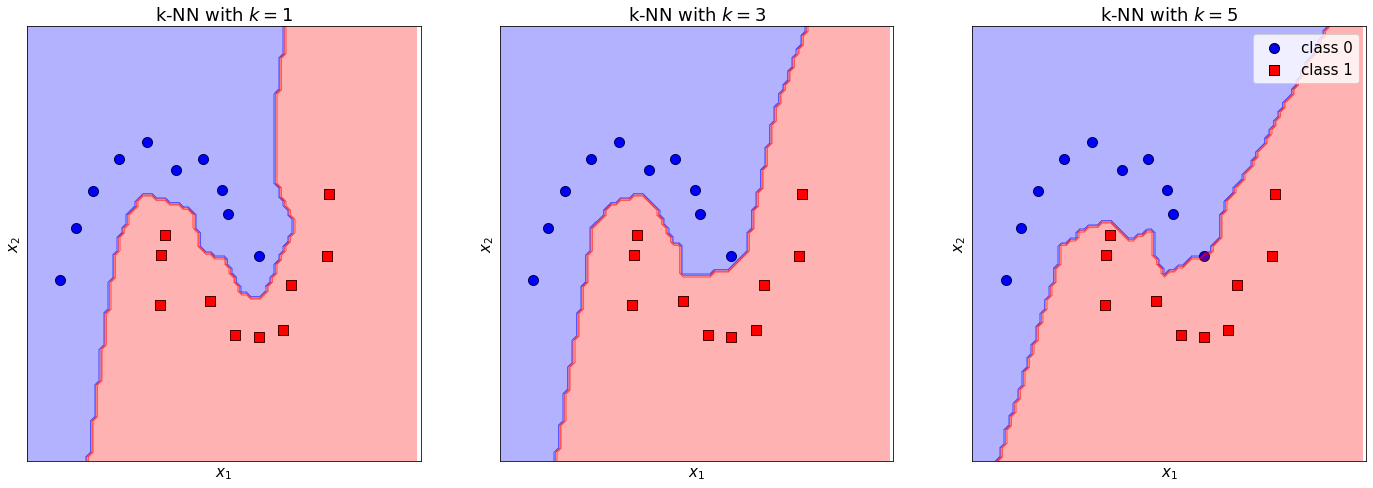

In [2]:
X, y = make_moons(n_samples=20, noise=0.1, random_state=42)

fig, axes = plt.subplots(1,3,figsize=[24,8])

k=5

for i,k in enumerate([1,3,5]):
    axes[i].scatter(X[y==0,0],X[y==0,1],color='b',edgecolor='k')
    axes[i].scatter(X[y==1,0],X[y==1,1],color='r',marker='s',edgecolor='k')


    axes[i].set_xlabel('$x_1$')
    axes[i].set_ylabel('$x_2$')
    plt.legend(['class 0','class 1'], loc='best')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlim([-1.5,3])
    axes[i].set_ylim([-1.5,2])

    model = KNeighborsClassifier(n_neighbors=k).fit(X,y)
    colours = ['b','r']
    axes[i].set_title(f'k-NN with $k={k}$')
    disp = DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
        alpha=0.3,
        grid_resolution=100,
        cmap=ListedColormap(colours),
        ax=axes[i],
    )


$k$-NN naturally extends to multiclass problems.

### 7.2 Generative models [Optional]

>**While you may be expected to use these at a high level in Sklearn, you do not need to understand their inner-workings as part of any assessment.**

A logistic regression classifier is known as a **discriminative model**. It gives us $p(y=k | \mathbf{x})$ for some class $k$ through the log-odds/logits, and only lets us discriminate between classes. 

**Generative models** on the other hand give us $p(\mathbf{x},y=k)$. This lets us perform classification by obtaining $p(y=k | \mathbf{x})$ through Bayes rule, as well as letting us generate new data points for each class by sampling from $p(\mathbf{x} | y=k)$.

Typically, discriminative classifiers are seen as being more accurate (see Murphy 9.4.1) but it is worth knowing about both.

We will consider Quadratic discriminant analysis (QDA), Linear discriminant analyis (LDA), and Gaussian Naive Bayes classifiers. These are all closely related.

We start by considering a classification problem where there are $K$ classes ($y\in \mathbb{Z}^+_{<K} = \{0,1,\ldots,K-1\}$ ). Let's look at the probability that the correct class label is $k$ given some data point $\mathbf{x}\in\mathbb{R}^D$: $p(y=k | \mathbf{x})$. By applying Bayes' rule we can write

\begin{equation}p(y=k | \mathbf{x}) = \frac{p(\mathbf{x}|y=k)p(y=k)}{p(\mathbf{x})}\end{equation}

It is sensible to classify a data point according to the most probable class label $\underset{k}{\operatorname{argmax}} p(y=k | \mathbf{x})$. As $p(\mathbf{x})$ is just some constant that is the same for all classes, we can ignore it.

\begin{equation}p(y=k | \mathbf{x}) \propto p(\mathbf{x}|y=k)p(y=k)\end{equation}

We will therefore classify according to 

\begin{equation}\underset{k}{\operatorname{argmax}} p(\mathbf{x}|y=k)p(y=k)\end{equation}

All the methods we are about to consider are different ways of modelling $p(\mathbf{x}|y=k)$ for each $k$. $p(y=k)$ is simply the fraction of data points within our training set that belong to class $k$. Note that these are generative models according to the definition above because $p(\mathbf{x}|y=k)p(y=k)=p(\mathbf{x},y=k)$.

#### 7.2.1 QDA

For Quadratic discriminant analysis (QDA) we model each $p(\mathbf{x}|y=k)$ with a Multivariate Gaussian distribution.

\begin{equation}p(\mathbf{x}|y=k)=\mathcal{N}(\mathbf{x}| \boldsymbol\mu_k , \boldsymbol\Sigma_k )=\frac{1}{(2\pi)^{D/2}|\boldsymbol\Sigma_k|^{1/2}}\exp\Bigr[-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu_k)^\top \boldsymbol\Sigma_k^{-1}(\mathbf{x}-\boldsymbol\mu_k)\Bigr]\end{equation}

where $\boldsymbol\mu\in\mathbb{R^D}$ is the mean vector, and $\boldsymbol\Sigma\in\mathbb{R^{D\times D}}$ is the covariance matrix of the distribution.

$$\boldsymbol\mu_k = \begin{bmatrix}\mu_1 & \mu_2 & \dots & \mu_{D}\end{bmatrix}^\top$$

$$\boldsymbol\Sigma_k = \begin{bmatrix}
\sigma_{1,1} & \sigma_{1,2}&\dots&\sigma_{1,D}\\
\sigma_{2,1} & \sigma_{2,2} &\dots & \sigma_{2,D}\\
\vdots&\vdots&\ddots&\vdots\\
\sigma_{D,1} & \sigma_{D,2} &\dots & \sigma_{D,D}\\
\end{bmatrix}$$

> **Multivariate Gaussians will crop up a lot in Week 9!**

These values can all be computed empirically from training data (which is equivalent to performing maximum likelihood estimation). Consider the subset of $N_k$ training points belonging to class $k$: $\mathfrak{D}_k =\{(\mathbf{x}^{(n)}, y^{(n)})\in N : y^{(n)}=k \}$.

Then 

\begin{equation}\mu_d = \frac{1}{N_k}\sum_{n=1}^{N_k}x^{(n)}_d\end{equation}

\begin{equation}\sigma_{i,j} = \frac{1}{N_k}\sum_{n=1}^{N_k}(x^{(n)}_i-\mu_i)(x^{(n)}_j-\mu_j)\end{equation}


Let's make it clear what is going on by considering a binary classification problem.

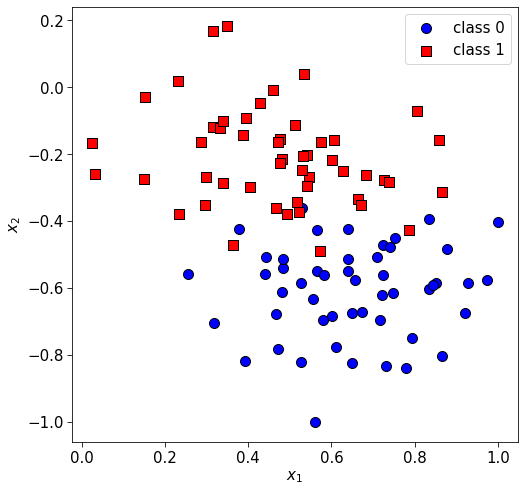

In [3]:
X, y = make_blobs(centers=2, random_state=44, cluster_std=1.8)
X = MaxAbsScaler().fit_transform(X)

fig, ax = plt.subplots(figsize=[8, 8])
ax.scatter(X[y == 0, 0], X[y == 0, 1], color="b", edgecolor="k")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="r", marker="s", edgecolor="k")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.legend(["class 0", "class 1"], loc="best")

When we fit a QDA model, we basically expect there to be $\boldsymbol\mu_0, \boldsymbol\Sigma_0$ for class 0, and $\boldsymbol\mu_1, \boldsymbol\Sigma_1$ for class 1.

In [4]:
model = QuadraticDiscriminantAnalysis(store_covariance=True).fit(X, y)

# Print the array containing mu_0 and mu_1
print(model.means_)

# Print the array containing sigma_0 and sigma_1
print(model.covariance_)

[[ 0.64887613 -0.61097152]
 [ 0.47130899 -0.2100766 ]]
[array([[0.029616  , 0.00198287],
       [0.00198287, 0.0192939 ]]), array([[ 0.03762276, -0.00663298],
       [-0.00663298,  0.02108555]])]


Looking at the values in the mean array we can see that they correspond to the centres of the blue and red clusters in the figure above, which makes sense. Plotting the decision boundary of the model, we can see it is quadratric (just about!), hence the name QDA.



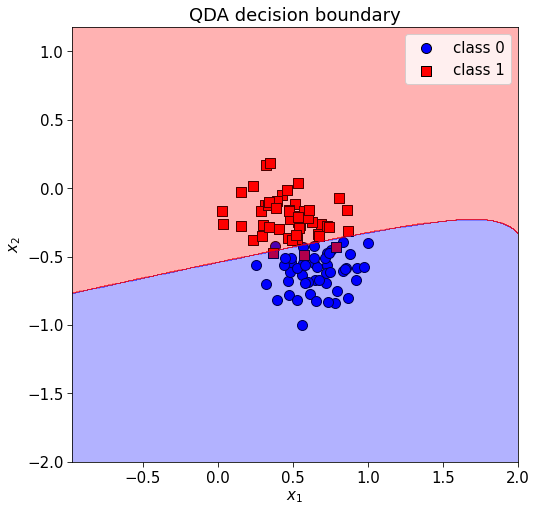

In [5]:
fig, ax = plt.subplots(figsize=[8, 8])
ax.scatter(X[y == 0, 0], X[y == 0, 1], color="b", edgecolor="k")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="r", marker="s", edgecolor="k")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.legend(["class 0", "class 1"], loc="best")
colours = ["b", "r"]
ax.set_title(f"QDA decision boundary")
disp = DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    response_method="predict",
    alpha=0.3,
    grid_resolution=500,
    cmap=ListedColormap(colours),
    ax=ax,
)

#### 7.2.2 LDA

In Linear Discriminant Analyis, we again model each $p(\mathbf{x}|y=k)$ using a multivariate Gaussian, except we assume that the covariance matrices are tied between classes $\boldsymbol\Sigma_0=\boldsymbol\Sigma_1=\dots=\boldsymbol\Sigma$. This means we just compute one covariance matrix for the whole dataset. This gives a linear decision boundary.

In [6]:
model = LinearDiscriminantAnalysis(store_covariance=True).fit(X, y)

# Print the array containing mu_0 and mu_1
print(model.means_)

# Print the array containing the shared sigma
print(model.covariance_)

[[ 0.64887613 -0.61097152]
 [ 0.47130899 -0.2100766 ]]
[[ 0.03294699 -0.00227855]
 [-0.00227855  0.01978593]]


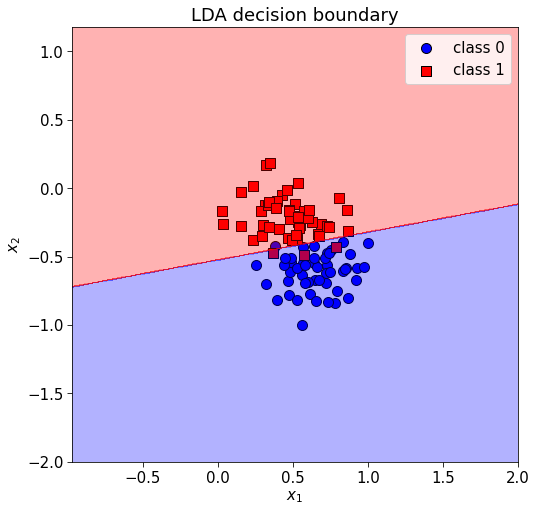

In [7]:
fig, ax = plt.subplots(figsize=[8, 8])
ax.scatter(X[y == 0, 0], X[y == 0, 1], color="b", edgecolor="k")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="r", marker="s", edgecolor="k")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.legend(["class 0", "class 1"], loc="best")
colours = ["b", "r"]
ax.set_title(f"LDA decision boundary")
disp = DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    response_method="predict",
    alpha=0.3,
    grid_resolution=500,
    cmap=ListedColormap(colours),
    ax=ax,
)

#### 7.2.3 Gaussian Naive Bayes

The starting point for Gaussian Naive Bayes is QDA. That is, for each class $k$ we have:

\begin{equation}p(\mathbf{x}|y=k)=\mathcal{N}(\mathbf{x}| \boldsymbol\mu_k , \boldsymbol\Sigma_k )\end{equation}

We however make the "naive" assumption that the features of our data are uncorrelated so that each $\boldsymbol\Sigma_k$ is a diagonal matrix. This let's us write each multivariate Gaussian as a product of univariate Gaussians.

\begin{equation}p(\mathbf{x}|y=k)= \prod_d p(x_d|y=k)=\prod_d \mathcal{N}(x_d| \mu_d , \sigma _{d,d} )\end{equation}

Other types of Naive Bayes exist where another univariate distribution is used in the equation above. For instance, Multinomial Naive Bayes uses a ... multinomial distribution! 


### 7.3 Model selection

Hopefully by now you are happy with the purpose of the train/validation/test split used in machine learning.

- The training set is for training different models
- The validation set is for evaluating trained models and selecting the best one
- The test set is for a final unbiased estimate of how well the chosen model will perform when deployed

On this course, the validation set was initially introduced in the context of hyperparameter tuning (specifically a regularisation hyperparameter). You can think of different types of models (e.g. logistic regression, $k$-NN, SVMs, QDA, etc. etc. ) as a hyperparameter that can be tuned.

In this sense, the purpose of the validation set is to perform **model selection** i.e. finding the best type of model with the best choice of hyperparameters. Exhaustively searching over all models and hyperparameters isn't possible so pragmatism is required, along with some intuition about what will work.

I have actually been guiding you through the model selection process in the labs, whereby you evaluate multiple models on the validation set, and at the very end select and evaluate **one** on the test set.

### 7.4 Cross-validation

Using a dedicated validation set has two disadvantages. Firstly, you are sacrificing data that could be used for training. Secondly, model selection will be sensitive to the way the dataset was partitioned. 

An alternative strategy is to evaluate models through cross-validation. This only requires splitting the original dataset into training and test.

Then, to perform $k$-fold cross-validation on a model:
- Split the training set into $k$ folds
- Use each fold as if it were a validation set: train a model on the other folds and evaluate on the given fold
- Avarege the performance across each fold

Let's examine cross-validation on the iris dataset (bearing in mind that the iris dataset is so easy we expect to see very high numbers).

In [8]:
# Load dataset
X, y = load_iris(return_X_y=True)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Standardise
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cross-validate a logistic regression classifier
scores = cross_validate(LogisticRegression(), X_train, y_train)

# Look at results
print(scores)

{'fit_time': array([0.005404  , 0.00348592, 0.00380802, 0.00352001, 0.00327802]), 'score_time': array([0.00028205, 0.00020981, 0.00024867, 0.00021005, 0.0002079 ]), 'test_score': array([0.95652174, 1.        , 0.86363636, 1.        , 0.95454545])}


This did 5-fold cross-validation by default. What we are interested in here is what is unhelpfully called `test_score` (this isn't test data!). There are 5 numbers that correspond to the 5 accuracies obtained when performing cross-validation. We can score the model by the mean of these quantities when comparing it to other models.

### 7.5 Grid search with $k$-fold cross validation

If we are performing a grid search over hyperparameter values, we can score each element in the grid by the mean accuracy obtained through cross-validation. Sklearn lets us do this quite simply. We will us as 1D grid of regularisation hyperparamters as an example.

In [9]:
hyperparameters = {"C": [1, 10, 100, 1000]}

clf = GridSearchCV(LogisticRegression(), hyperparameters)
clf.fit(X_train, y_train)

print(clf.cv_results_)

{'mean_fit_time': array([0.00433664, 0.00555158, 0.00785565, 0.00831118]), 'std_fit_time': array([0.00108907, 0.00041095, 0.00083728, 0.00139964]), 'mean_score_time': array([0.00020261, 0.00029221, 0.00025916, 0.0002676 ]), 'std_score_time': array([8.86122029e-06, 6.34663988e-05, 3.65858728e-05, 9.46937369e-05]), 'param_C': masked_array(data=[1, 10, 100, 1000],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.95652174, 0.95652174, 0.95652174, 0.95652174]), 'split1_test_score': array([1.        , 1.        , 1.        , 0.95652174]), 'split2_test_score': array([0.86363636, 0.81818182, 0.81818182, 0.81818182]), 'split3_test_score': array([1., 1., 1., 1.]), 'split4_test_score': array([0.95454545, 0.95454545, 1.        , 1.        ]), 'mean_test_score': array([0.95494071, 0.9458498 , 0.95494071, 0.94624506]), 'std_test_score': array([0.04979923, 0.0668627

Quite a bit to process there, but you can see `mean_test_score` has the mean accuracies for each value of `C` in the grid. 

To make things easier, this `GridSearchCV` object will train a model on all the training data with the best hyperparameters so it can then be directly used just like any other sklearn model.

There are many techniques for hyperparameter tuning that are better than grid search, but these are beyond the scope of this course!

### 7.6 Pipelines

In this iris dataset example above I started by fitting a `StandardScaler` to the training data and then applied it to both the training data and test data. Here, I had to be careful not to accidentally use the test data for fitting the scalar as this would cause information about the test set to leak into our training pipeline.

In sklearn, we can make an actual pipeline object to help prevent such leaks:

In [10]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", StandardScaler()), ("logreg", LogisticRegression())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

This jointly fits the scaler and the model using training data and can be used just like any other classifier object.

### 7.7 Evaluating binary classifiers

We typically default to accuracy (the proportion of correct classified examples) when it comes to evaluating classifiers (binary or otherwise), but this isn't that informative if there is a significant class imbalance. For instance, consider a scenario where there are 2 classes and 90% of the examples are in class 0 with the remaining 10% in class 1. A dummy classifier could just predict everything as being in class 0, and would get 90% accuracy which sounds vastly better than it is.

If we denote one class as being positive with $P$ examples, and the other as *negative* with $N$ examples then we can define the true positive rate:

\begin{equation}TPR =\frac{TP}{P}\end{equation}

and the false positive rate:

\begin{equation}FPR = \frac{FP}{N}\end{equation}

Where positives are e.g. some rare disease we would want high $TPR$ and low $FPR$.

The predictions of a binary classifier are made according to some threshold function

\begin{equation}\hat{y}=\begin{cases}
          1 \quad &\text{if} \, f(\mathbf{x})\geq  \tau \\
          0 \quad &\text{if} \, f(\mathbf{x})<\tau \\
     \end{cases}\end{equation}
     
and changing $\tau$ trades off $TPR$ against $FPR$. With this, we can summarise the performance of a binary classifier in the context of unbalanced classes by considering its Receiver Operating Characteristic (ROC) curve, which is a plot of $TPR$ against $FPR$ as we vary $\tau$.

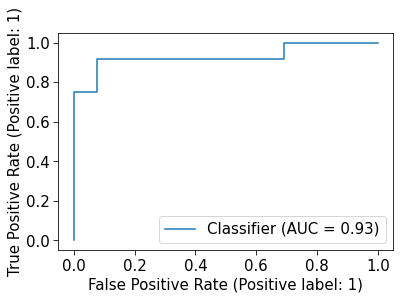

In [11]:
# Generate dummy data for a 2 class problem
X, y = make_classification(random_state=0)

# Split into train and val (let's ignore test)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

# Fit a Logistic regression classifier
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Decision function gives f(x) (log-odds)
y_pred = clf.decision_function(X_val)
RocCurveDisplay.from_predictions(y_val, y_pred)

Ideally we would want the curve to hug the top-left corner. With this in mind, we can summarise the curve by the area underneath it (the AUC).

In the lecture we also consider PR curves, but these effectively show the same information as ROC curves.

<hr style="border:2px solid black"> </hr>

#### Written by Elliot J. Crowley and &copy; The University of Edinburgh 2022-24